In [1]:
!git config --global user.email "sule.kocak0101@gmail.com"
!git config --global user.name "SuleKocak"
!git clone https://github.com/SuleKocak/sketch_generation.git


Cloning into 'sketch_generation'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [2]:
%cd sketch_generation

/content/sketch_generation


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/myth_ai_sketch_generation

Mounted at /content/drive
data  Sketch_Generation.ipynb  subset  Technical_Assignment.ipynb


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/myth_ai_sketch_generation


/content/drive/MyDrive/Colab Notebooks/myth_ai_sketch_generation


In [5]:
!ls

data  Sketch_Generation.ipynb  subset  Technical_Assignment.ipynb


In [63]:


!pip install ndjson
!pip install torchmetrics[image] torch-fidelity
import pandas as pd
import ndjson
import pathlib
import json
import os
import json
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
from torch.utils.data import Dataset, DataLoader
from IPython.display import Image
import torch.nn as nn
from google.colab import drive
drive.mount('/content/drive')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# let's first have an exploratory data analysis:
bus_indices_path = str(pathlib.Path.cwd()) + "/subset/bus/indices.json"
bus_indices = pd.read_json(bus_indices_path, lines=True)
cat_indices_path = str(pathlib.Path.cwd()) + "/subset/cat/indices.json"
cat_indices = pd.read_json(cat_indices_path, lines=True)
rabbit_indices_path = str(pathlib.Path.cwd()) + "/subset/rabbit/indices.json"
rabbit_indices = pd.read_json(rabbit_indices_path, lines=True)


In [8]:
print(bus_indices.head())
print(bus_indices.dtypes)
print(cat_indices.head())
print(cat_indices.dtypes)
print(rabbit_indices.head())
print(rabbit_indices.dtypes)

                                               train  \
0  [128037, 5192, 50057, 109259, 73349, 117583, 2...   

                                                test  
0  [109624, 18053, 45472, 82769, 133366, 123631, ...  
train    object
test     object
dtype: object
                                               train  \
0  [68268, 43567, 42613, 117952, 45891, 21243, 95...   

                                                test  
0  [107874, 60461, 70209, 1224, 52888, 67709, 111...  
train    object
test     object
dtype: object
                                               train  \
0  [89256, 100879, 95816, 84434, 33867, 80232, 53...   

                                                test  
0  [33543, 148066, 32456, 8204, 31686, 3031, 4611...  
train    object
test     object
dtype: object


In [9]:
# Normally i use pandas for data analysis that's why it's my first choice but lets use them in dictionary format:

with open(bus_indices_path) as f:
    bus_indices = json.load(f)

with open(cat_indices_path) as f:
    cat_indices = json.load(f)

with open(rabbit_indices_path) as f:
    rabbit_indices = json.load(f)


In [10]:
bus_data_path = str(pathlib.Path.cwd()) + "/data/bus.ndjson"
cat_data_path = str(pathlib.Path.cwd()) + "/data/cat.ndjson"
rabbit_data_path = str(pathlib.Path.cwd()) + "/data/rabbit.ndjson"

# BUS DATA

In [11]:
with open(bus_data_path) as f:
    reader = ndjson.reader(f)
    bus_data = list(reader)

with open(cat_data_path) as f:
    cat_data = list(ndjson.reader(f))

with open(rabbit_data_path) as f:
    rabbit_data = list(ndjson.reader(f))

In [12]:
def filter_data_by_indices(data, indices):
    train_idx = indices['train']
    test_idx = indices['test']

    train_data = [data[i]['drawing'] for i in train_idx]
    test_data = [data[i]['drawing'] for i in test_idx]

    return train_data, test_data

In [13]:
bus_data_train, bus_data_test = filter_data_by_indices(bus_data, bus_indices)
cat_data_train, cat_data_test = filter_data_by_indices(cat_data, cat_indices)
rabbit_data_train, rabbit_data_test = filter_data_by_indices(rabbit_data, rabbit_indices)

In [14]:
def plot_sketch(sketch_arr, title=None):
    print("how many strokes: ", len(sketch_arr))
    for stroke in sketch_arr:
        x, y = stroke
        plt.plot(x, y, linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

how many strokes:  4


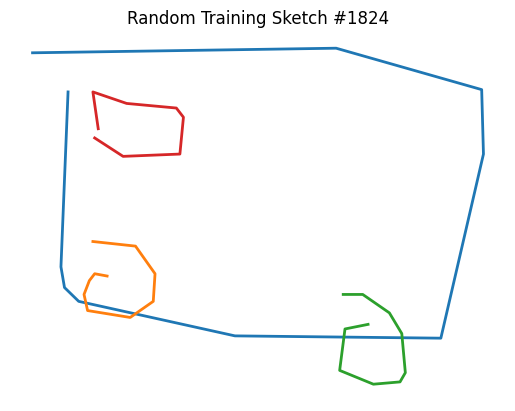

In [15]:
# picking some random data to see if it's been filtered correctly:
index = random.randint(0, len(bus_data_train) - 1)
plot_sketch(bus_data_train[index], title=f"Random Training Sketch #{index}")

In [16]:
def to_stroke5(sketch_coords):
    stroke5 = []
    prev_x, prev_y = 0, 0
    for stroke in sketch_coords:
        x_seq, y_seq = stroke
        for i in range(len(x_seq)):
            x, y = x_seq[i], y_seq[i]
            dx = x - prev_x
            dy = y - prev_y
            prev_x, prev_y = x, y

            p1 = 1 if i < len(x_seq) - 1 else 0
            p2 = 1 if i == len(x_seq) - 1 else 0
            p3 = 0
            stroke5.append([dx, dy, p1, p2, p3])
    if stroke5:
        stroke5[-1][-1] = 1
    return np.array(stroke5, dtype=np.float32)


In [17]:
def plot_multiple_stroke5(sketch_coords, num_samples=8, title="Stroke-5 Sketches"):
    indices = random.sample(range(len(sketch_coords)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)

    for i, idx in enumerate(indices):
        ax = axes[i]
        stroke5 = to_stroke5(sketch_coords[idx])
        x, y = 0, 0
        xs, ys = [x], [y]
        for dx, dy, *_ in stroke5:
            x += dx * 255
            y += dy * 255
            xs.append(x)
            ys.append(y)
        ax.plot(xs, ys, linewidth=2)
        ax.invert_yaxis()
        ax.axis("off")

    plt.tight_layout()
    plt.show()


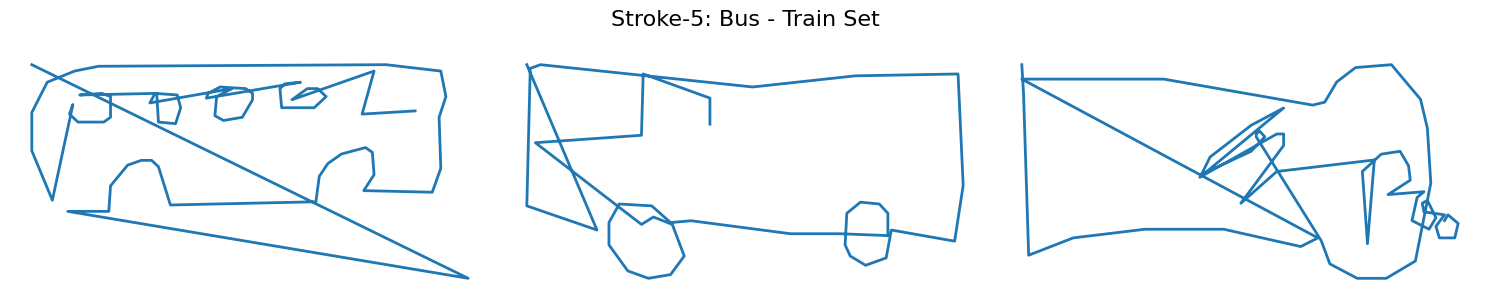

In [18]:
plot_multiple_stroke5(bus_data_train, num_samples=3, title="Stroke-5: Bus - Train Set")


In [19]:
class StrokeDataset(Dataset):
    def __init__(self, drawings, labels, max_len=200):
        self.drawings = drawings
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        stroke5 = to_stroke5(self.drawings[idx])
        stroke5[:, 0] /= 255.
        stroke5[:, 1] /= 255.
        if len(stroke5) > self.max_len:
            stroke5 = stroke5[:self.max_len]
            mask = torch.ones(self.max_len, dtype=torch.bool)
        else:
            pad_len = self.max_len - len(stroke5)
            stroke5 = np.pad(stroke5, ((0, pad_len), (0,0)), 'constant')
            mask = torch.cat([torch.ones(len(stroke5)-pad_len), torch.zeros(pad_len)]).bool()
        stroke5 = torch.tensor(stroke5, dtype=torch.float32)
        label = self.labels[idx]
        return stroke5, mask, label

In [20]:
import torch
import torch.nn as nn

class ConditionalTransformer(nn.Module):
    def __init__(self, stroke_dim=5, emb_dim=256, n_heads=8, n_layers=8, num_classes=3, num_timesteps=1000, max_len=200):
        super().__init__()

        self.stroke_proj = nn.Linear(stroke_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(max_len, emb_dim))  # learnable positional encoding

        self.time_embed = nn.Embedding(num_timesteps, emb_dim)
        self.class_embed = nn.Embedding(num_classes, emb_dim)

        # Combines t + class → (emb_dim * 2) → emb_dim
        self.cond_proj = nn.Sequential(
            nn.Linear(emb_dim * 2, emb_dim),
            nn.ReLU()
        )

        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=n_heads,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.output_proj = nn.Linear(emb_dim, stroke_dim)

    def forward(self, x, t, c, mask=None):
        """
        x:      (B, L, 5)       - input strokes
        t:      (B,)            - timesteps
        c:      (B,)            - class labels
        mask:   (B, L)          - attention mask (True = keep, False = pad)
        """

        # 1. Project strokes to embeddings
        x = self.stroke_proj(x)                  # (B, L, emb_dim)
        x = x + self.pos_emb[:x.size(1)]         # add positional embeddings

        # 2. Get time and class embeddings
        t_emb = self.time_embed(t)               # (B, emb_dim)
        c_emb = self.class_embed(c)              # (B, emb_dim)

        # 3. Combine + project to get conditioning vector
        cond = torch.cat([t_emb, c_emb], dim=-1) # (B, 2*emb_dim)
        cond = self.cond_proj(cond)              # (B, emb_dim)

        # 4. Inject conditioning into sequence (e.g., like cross-attention)
        x = x + cond.unsqueeze(1)                # broadcast over sequence length

        # 5. Transformer Encoding
        pad_mask = ~mask if mask is not None else None
        x = self.transformer(x, src_key_padding_mask=pad_mask)

        # 6. Predict next stroke token (Δx, Δy, pen states)
        return self.output_proj(x)               # (B, L, 5)


In [21]:
# === LOSS FUNCTION ===
loss_fn = nn.MSELoss()


In [22]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

class Diffusion:
    def __init__(self, timesteps=500, device='cpu'):
        self.timesteps = timesteps
        self.device = device
        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.alpha_cumprod[t].sqrt().view(-1, 1, 1)
        sqrt_one_minus = (1 - self.alpha_cumprod[t]).sqrt().view(-1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus * noise, noise

In [23]:
def train(model, diffusion, dataloader, optimizer, epochs=100, ckpt_path='model.pt'):
    start_time = time.time()
    loss_history = []
    best_loss = float('inf')
    model.train()

    for epoch in range(epochs):
        if stop_training.is_set():
            print("🛑 Training stopped manually.")
            break

        total_loss = 0
        for step, (x, mask, label) in enumerate(dataloader):
            x, mask, label = x.to(DEVICE), mask.to(DEVICE), label.to(DEVICE)
            t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=DEVICE)
            x_noisy, noise = diffusion.q_sample(x, t)
            pred = model(x_noisy, t, label, mask)
            loss = ((noise - pred)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, — Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), ckpt_path.replace(".pt", "_best.pt"))

        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), ckpt_path.replace(".pt", f"_epoch{epoch+1}.pt"))

    torch.save(model.state_dict(), ckpt_path)

    heartbeat_running.clear()

    duration = time.time() - start_time
    mins, secs = divmod(int(duration), 60)
    print(f"✅ Training completed in {mins} min {secs} sec")

    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.show()




In [24]:
def train_category(cls_name, drawings, save_dir, epochs=50, max_len=200):
    print(f"🚀 Training category: {cls_name}")

    # Dummy labels since we're doing class-agnostic training
    labels = [0] * len(drawings)

    # Dataset & DataLoader
    dataset = StrokeDataset(drawings=drawings, labels=labels, max_len=max_len)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Model & Diffusion
    model = ConditionalTransformer(num_classes=1).to(DEVICE)
    diffusion = Diffusion(timesteps=500, device=DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Output path
    model_path = f"{save_dir}/model_{cls_name}.pt"

    # Train
    train(model, diffusion, dataloader, optimizer, epochs=epochs, ckpt_path=model_path)

    print(f"✅ Training completed for {cls_name} — Model saved to {model_path}")


In [25]:
# Output folder creation:

import os

save_dir = "/content/drive/MyDrive/sketch_models"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
"""categories = {
    'bus': bus_data_train,
    'cat': cat_data_train,
    'rabbit': rabbit_data_train
}

for cls, data in categories.items():
    train_category(cls_name=cls, drawings=data, save_dir="/content/drive/MyDrive/sketch_models")


"""

In [28]:
# import threading
# from threading import Event
# import time

# def heartbeat(interval=120):
#     heartbeat_running.set()
#     while heartbeat_running.is_set() and not stop_training.is_set():
#         print("💓 Training heartbeat — still running...")
#         time.sleep(interval)


# heartbeat_running = Event()
# stop_training = Event()
# #

# stop_training.clear()
# heartbeat_thread = threading.Thread(target=heartbeat)
# heartbeat_thread.start()

# t = threading.Thread(target=lambda: train_category('bus', bus_data_train, save_dir=save_dir))
# t.start()


#train_category('bus', bus_data_train, save_dir=save_dir)

💓 Training heartbeat — still running...
🚀 Training category: bus


In [29]:
# stop training if it's taking too long or there's an error:
# stop_training.set()
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [60]:
@torch.no_grad()
def sample(model, diffusion, label, seq_len=200):
    model.eval()
    x = torch.randn(1, seq_len, 5).to(DEVICE)
    label = torch.tensor([label], device=DEVICE)
    for t_inv in reversed(range(diffusion.timesteps)):
        t = torch.tensor([t_inv], device=DEVICE)
        eps = model(x, t, label)
        beta = diffusion.betas[t].view(1,1,1)
        alpha = diffusion.alphas[t].view(1,1,1)
        alpha_cum = diffusion.alpha_cumprod[t].view(1,1,1)
        x = (1 / alpha.sqrt()) * (x - beta / (1 - alpha_cum).sqrt() * eps)

        """After printing the After printing [dx, dy, p1, p2, p3]:
        dx, dy = delta movement
        p1, p2, p3 = pen states
        p1 = pen down
        p2 = end of stroke
        p3 = end of drawing
        It is seen that pen state is not binary but float numbers. This is caused by the model's regressing those values.
        So i need to make them binary again:
        """
        # Clamp pen states to binary logic
        x[..., 2] = (x[..., 2] > 0.5).float()  # pen down
        x[..., 3] = (x[..., 3] > 0.5).float()  # end of stroke
        x[..., 4] = (x[..., 4] > 0.5).float()
        x[..., 0:2] = x[..., 0:2].clamp(-1.0, 1.0)
        if t_inv > 0:
            noise = torch.randn_like(x)
            x += beta.sqrt() * noise
    return x.squeeze(0).cpu().numpy()

In [21]:
import matplotlib.pyplot as plt
def plot_sample(stroke5, title="Generated Sketch"):
    x, y = 0, 0
    xs, ys = [], []
    stroke_x, stroke_y = [x], [y]

    scale = 255

    for dx, dy, _, p2, _ in stroke5:
        x += dx * scale
        y += dy * scale
        stroke_x.append(x)
        stroke_y.append(y)

        if p2 == 1:  # End of stroke
            xs.append(stroke_x)
            ys.append(stroke_y)
            stroke_x, stroke_y = [x], [y]

    # Append last stroke if it didn't end properly
    if stroke_x and stroke_y:
        xs.append(stroke_x)
        ys.append(stroke_y)

    plt.figure(figsize=(3, 3))
    for sx, sy in zip(xs, ys):
        plt.plot(sx, sy, linewidth=2)

    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.title(title)
    plt.show()


In [57]:
#mini_bus = bus_data_train[:1000]
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_sample_colored(stroke5, title="Generated Sketch (Colored Strokes)"):
    x, y = 0, 0
    strokes = []
    stroke_x, stroke_y = [x], [y]

    scale = 255

    for dx, dy, _, p2, _ in stroke5:
        x += dx * scale
        y += dy * scale
        stroke_x.append(x)
        stroke_y.append(y)

        if p2 == 1:  # end of stroke
            strokes.append((stroke_x, stroke_y))
            stroke_x, stroke_y = [x], [y]

    if stroke_x and stroke_y:
        strokes.append((stroke_x, stroke_y))

    plt.figure(figsize=(3, 3))
    colors = cm.viridis(np.linspace(0, 1, len(strokes)))

    for (sx, sy), color in zip(strokes, colors):
        plt.plot(sx, sy, linewidth=2, color=color)

    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.title(title)
    plt.show()


In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imageio

def generate_gif(stroke5, filename="sample.gif", scale=255):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import imageio
    import numpy as np

    x, y = 0, 0
    stroke_x, stroke_y = [x], [y]
    strokes = []

    for dx, dy, _, p2, _ in stroke5:
        x += dx * scale
        y += dy * scale
        stroke_x.append(x)
        stroke_y.append(y)

        if p2 == 1:
            strokes.append((stroke_x.copy(), stroke_y.copy()))
            stroke_x, stroke_y = [x], [y]

    if stroke_x and stroke_y:
        strokes.append((stroke_x, stroke_y))

    frames = []
    colors = cm.plasma(np.linspace(0, 1, len(strokes)))

    for i in range(1, len(strokes) + 1):
        fig, ax = plt.subplots(figsize=(3, 3))
        for (sx, sy), color in zip(strokes[:i], colors[:i]):
            ax.plot(sx, sy, linewidth=2, color=color)

        ax.invert_yaxis()
        ax.axis("off")

        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        image = np.frombuffer(renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
        plt.close(fig)

    imageio.mimsave(filename, frames, fps=3)



In [67]:
def load_and_sample(cls_name, save_dir, label=0, seq_len=200):
    # Load model
    model = ConditionalTransformer(num_classes=1).to(DEVICE)
    model.load_state_dict(torch.load(f"{save_dir}/model_{cls_name}.pt"))
    model.eval()

    # Init diffusion
    diffusion = Diffusion(device=DEVICE)

    # Generate a sample
    sample_stroke = sample(model, diffusion, label=label, seq_len=seq_len)
    print("Sample shape:", sample_stroke.shape)
    print("First 10 steps:", sample_stroke[:10])
    print(sample_stroke[:10])

    plot_sample_colored(sample_stroke, title=f"{cls_name.capitalize()} Sample Output")
    #generate_gif(sample_stroke, filename=f"{cls_name}_sample.gif")
    generate_gif(sample_stroke, scale=1, filename=f"/content/drive/MyDrive/sketch_models/{cls_name}_sample.gif")
    Image(filename=f"/content/drive/MyDrive/sketch_models/{cls_name}_sample.gif")



Sample shape: (200, 5)
First 10 steps: [[-0.25175497  0.33217105  0.          0.          1.        ]
 [ 0.00176804 -0.03913869  0.          0.          0.        ]
 [-0.26874495 -0.0537185   1.          0.          1.        ]
 [-0.28392553 -0.17679523  1.          0.          0.        ]
 [-0.03311433  0.10322873  0.          0.          1.        ]
 [ 0.46022433 -0.22273962  1.          0.          1.        ]
 [ 0.01287078 -0.08095241  1.          0.          0.        ]
 [ 0.04960487 -0.10941175  0.          0.          0.        ]
 [ 0.044501   -0.3512256   0.          0.          0.        ]
 [-0.5661066  -0.3378518   0.          0.          1.        ]]
[[-0.25175497  0.33217105  0.          0.          1.        ]
 [ 0.00176804 -0.03913869  0.          0.          0.        ]
 [-0.26874495 -0.0537185   1.          0.          1.        ]
 [-0.28392553 -0.17679523  1.          0.          0.        ]
 [-0.03311433  0.10322873  0.          0.          1.        ]
 [ 0.46022433 -

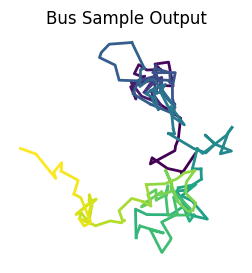

In [68]:
load_and_sample('bus', save_dir, label=0, seq_len=200)

In [41]:
#train_category('cat', cat_data_train, save_dir=save_dir)

🚀 Training category: cat
[1/20] Loss: 0.2677
[2/20] Loss: 0.1129
[3/20] Loss: 0.0876
[4/20] Loss: 0.0719
[5/20] Loss: 0.0628
[6/20] Loss: 0.0556
[7/20] Loss: 0.0491
[8/20] Loss: 0.0482
[9/20] Loss: 0.0462
[10/20] Loss: 0.0440
[11/20] Loss: 0.0392
[12/20] Loss: 0.0404
[13/20] Loss: 0.0404
[14/20] Loss: 0.0374
[15/20] Loss: 0.0356
[16/20] Loss: 0.0342
[17/20] Loss: 0.0335
[18/20] Loss: 0.0342
[19/20] Loss: 0.0322
[20/20] Loss: 0.0309
✅ Training finished for cat — model saved to: /content/drive/MyDrive/sketch_models/model_cat.pt


In [32]:
#train_category('rabbit', rabbit_data_train, save_dir=save_dir)

# RABBIT DATA

how many strokes:  7


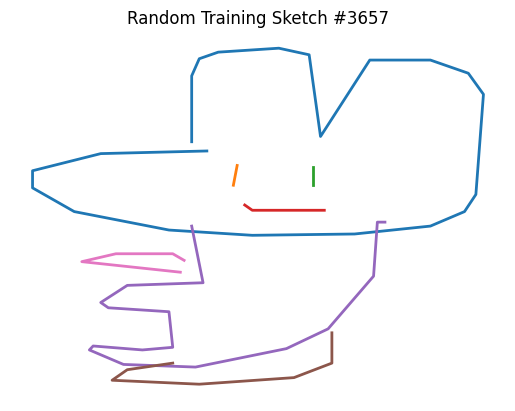

In [26]:
# picking some random data to see if it's been filtered correctly:
index = random.randint(0, len(rabbit_data_train) - 1)
plot_sketch(rabbit_data_train[index], title=f"Random Training Sketch #{index}")

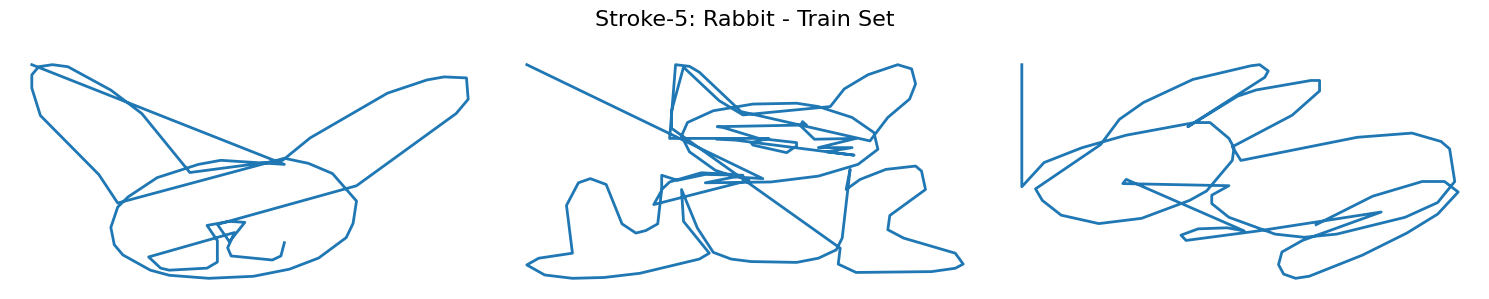

In [27]:
plot_multiple_stroke5(rabbit_data_train, num_samples=3, title="Stroke-5: Rabbit - Train Set")


In [28]:
class SketchRNN(nn.Module):
    def __init__(self, input_size=5, hidden_size=256, num_layers=2, dropout=0.2):
        super(SketchRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        return self.fc(output)


In [50]:
def train_sketchrnn(model, dataloader, optimizer, epochs=20, ckpt_path="rabbit_model.pt"):
    model.train()
    loss_fn = nn.MSELoss()
    loss_history = []

    best_loss = float("inf")

    for epoch in range(epochs):
        total_loss = 0

        for x, mask, _ in dataloader:
            x = x.to(DEVICE)
            mask = mask.to(DEVICE)

            output = model(x)
            loss = loss_fn(output[mask], x[mask])  # Masked MSE loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"[SketchRNN] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # 🔥 Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), ckpt_path)
            print(f"✅ Saved best model at epoch {epoch+1} with loss {best_loss:.4f}")

    # 📉 Plot loss
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, marker='o', linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("SketchRNN Training Loss")
    plt.grid(True)
    plt.show()

    return loss_history


In [53]:
model = SketchRNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Labels aren't used — dummy list of zeros
rabbit_labels = [0] * len(rabbit_data_train)

# Dataset & DataLoader
rabbit_dataset = StrokeDataset(drawings=rabbit_data_train, labels=rabbit_labels, max_len=200)
rabbit_loader = DataLoader(rabbit_dataset, batch_size=64, shuffle=True)


[SketchRNN] Epoch 1/30, Loss: 0.0762
✅ Saved best model at epoch 1 with loss 0.0762
[SketchRNN] Epoch 2/30, Loss: 0.0454
✅ Saved best model at epoch 2 with loss 0.0454
[SketchRNN] Epoch 3/30, Loss: 0.0141
✅ Saved best model at epoch 3 with loss 0.0141
[SketchRNN] Epoch 4/30, Loss: 0.0092
✅ Saved best model at epoch 4 with loss 0.0092
[SketchRNN] Epoch 5/30, Loss: 0.0072
✅ Saved best model at epoch 5 with loss 0.0072
[SketchRNN] Epoch 6/30, Loss: 0.0045
✅ Saved best model at epoch 6 with loss 0.0045
[SketchRNN] Epoch 7/30, Loss: 0.0023
✅ Saved best model at epoch 7 with loss 0.0023
[SketchRNN] Epoch 8/30, Loss: 0.0014
✅ Saved best model at epoch 8 with loss 0.0014
[SketchRNN] Epoch 9/30, Loss: 0.0010
✅ Saved best model at epoch 9 with loss 0.0010
[SketchRNN] Epoch 10/30, Loss: 0.0008
✅ Saved best model at epoch 10 with loss 0.0008
[SketchRNN] Epoch 11/30, Loss: 0.0006
✅ Saved best model at epoch 11 with loss 0.0006
[SketchRNN] Epoch 12/30, Loss: 0.0006
✅ Saved best model at epoch 12 wit

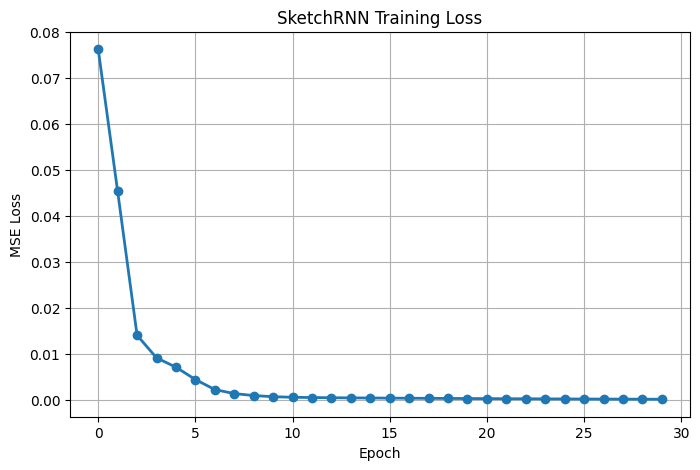

[0.07624229473198295,
 0.04536974635331115,
 0.014107441849959124,
 0.009206060456574723,
 0.007176470405950098,
 0.00449410927701433,
 0.00231719569519613,
 0.0014417016089769306,
 0.0010152518675828673,
 0.0007643235634543761,
 0.0006445798738177415,
 0.000584984179675152,
 0.0005428764852695167,
 0.0005136305904890867,
 0.0004850035163671799,
 0.00045919112893040917,
 0.000436074009045045,
 0.00041157334440856415,
 0.00039044778314300453,
 0.0003709329998826572,
 0.00035008623625839923,
 0.0003307968703214269,
 0.0003151361058261483,
 0.000296801693661874,
 0.0002808279759557562,
 0.0002650536341328696,
 0.0002520834833567452,
 0.00024062430632158308,
 0.00022910174169981035,
 0.00021934394548931842]

In [54]:
train_sketchrnn(model, rabbit_loader, optimizer, epochs=30, ckpt_path="rabbit_model.pt")

It looks like the model has overfitting

In [30]:
@torch.no_grad()
def sample_sketchrnn(model, seq_len=200):
    model.eval()
    x = torch.zeros(1, seq_len, 5).to(DEVICE)
    output = model(x).squeeze(0).cpu().numpy()
    output[-1][-1] = 1  # force end
    return output

def sample_sketchrnn_and_plot(model, seq_len=200):
    sample = sample_sketchrnn(model, seq_len)
    plot_sample_colored(sample, title="SketchRNN Sample Output")


In [37]:
@torch.no_grad()
def sample_sketchrnn_batch(model, num_samples=3, seq_len=200):
    model.eval()
    x = torch.zeros(num_samples, seq_len, 5).to(DEVICE)
    output = model(x).cpu().numpy()
    for i in range(num_samples):
        output[i][-1][-1] = 1  # force end-of-sketch
    return output


In [33]:
def plot_sketchrnn_samples(samples, title="SketchRNN Samples"):
    num_samples = samples.shape[0]
    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_samples):
        ax = axes[i] if num_samples > 1 else axes
        stroke = samples[i]
        x, y = 0, 0
        xs, ys = [x], [y]
        for dx, dy, p1, p2, p3 in stroke:
            x += dx * 255
            y += dy * 255
            if p2 > 0.5:  # end of stroke
                ax.plot(xs, ys, linewidth=2)
                xs, ys = [x], [y]
            else:
                xs.append(x)
                ys.append(y)
        ax.plot(xs, ys, linewidth=2)
        ax.invert_yaxis()
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [38]:
model = SketchRNN().to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/sketch_models/sketchrnn_rabbit.pt"))


<All keys matched successfully>

In [39]:
def sample_sketchrnn_and_plot(model, seq_len=200):
    model.eval()
    x = torch.zeros(1, seq_len, 5).to(DEVICE)
    sample = model(x)[0].detach().cpu().numpy()
    sample[-1][-1] = 1  # force end of sketch
    plot_sketchrnn_samples(sample[np.newaxis, ...], title="SketchRNN Sample Output")



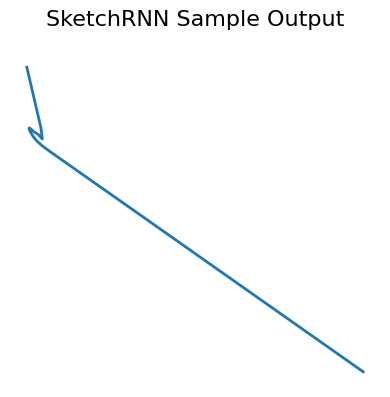

In [65]:
sample_sketchrnn_and_plot(model, seq_len=200)

In [34]:
samples = sample_sketchrnn_batch(model, num_samples=3)
plot_sketchrnn_samples(samples, title="Rabbit SketchRNN Outputs")

NameError: name 'model' is not defined

In [57]:
@torch.no_grad()
def evaluate_sketchrnn(model_path, num_samples=3, seq_len=200, title="SketchRNN Output", save_gif=False, tag="sample"):
    import matplotlib.pyplot as plt
    from PIL import Image
    import numpy as np

    # Load model
    model = SketchRNN().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    def sample_single():
        x = torch.zeros(1, seq_len, 5).to(DEVICE)
        x[0, 0, -1] = 1  # initial pen state: end of stroke
        for t in range(1, seq_len):
            out = model(x)
            x[0, t] = out[0, t-1]
        return x.squeeze(0).cpu().numpy()

    all_samples = [sample_single() for _ in range(num_samples)]

    # 🖼️ Plot samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, sample in enumerate(all_samples):
        ax = axes[i]
        x, y = 0, 0
        xs, ys = [x], [y]
        for dx, dy, p1, p2, p3 in sample:
            x += dx * 255
            y += dy * 255
            if p2 == 1:
                ax.plot(xs, ys, 'k-', linewidth=2)
                xs, ys = [], []
            xs.append(x)
            ys.append(y)
        ax.axis("off")
        ax.invert_yaxis()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # 🌀 Export GIF
    if save_gif:
        frames = []
        for sample in all_samples:
            fig, ax = plt.subplots()
            x, y = 0, 0
            xs, ys = [x], [y]
            for dx, dy, p1, p2, p3 in sample:
                x += dx * 255
                y += dy * 255
                if p2 == 1:
                    ax.plot(xs, ys, 'k-', linewidth=2)
                    xs, ys = [], []
                xs.append(x)
                ys.append(y)
            ax.axis("off")
            ax.invert_yaxis()
            fig.canvas.draw()
            image = np.array(fig.canvas.buffer_rgba())
            frames.append(Image.fromarray(image))
            plt.close(fig)
        frames[0].save(f"{tag}.gif", save_all=True, append_images=frames[1:], duration=100, loop=0)


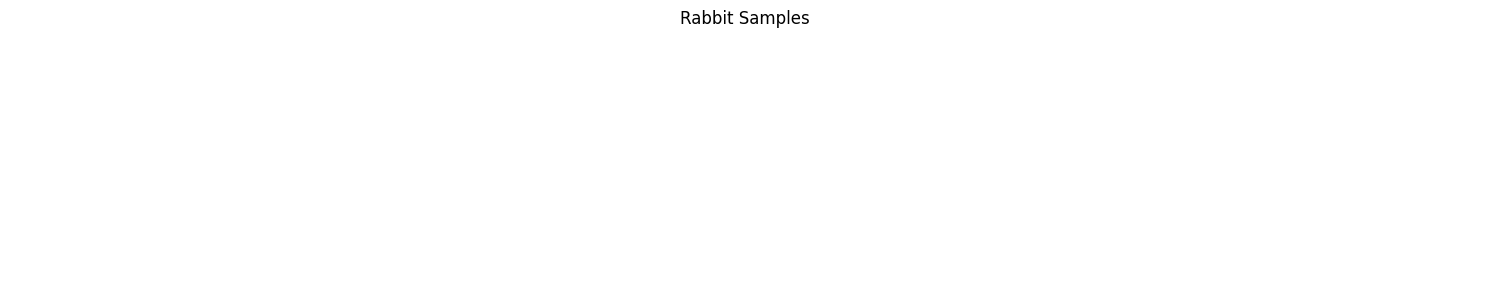

In [58]:
evaluate_sketchrnn("rabbit_model.pt", num_samples=3, title="Rabbit Samples", save_gif=True, tag="rabbit_sketchrnn")


In [68]:
@torch.no_grad()
def test_sketchrnn_sample(model_path="rabbit_model.pt", seq_len=200):
    import matplotlib.pyplot as plt
    from PIL import Image
    import numpy as np

    print("✅ Starting SketchRNN test...")

    # Load model
    model = SketchRNN().to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("✅ Model loaded successfully")

    # Sample
    x = torch.zeros(1, seq_len, 5).to(DEVICE)
    x[0, 0, -1] = 1
    for t in range(1, seq_len):
        out = model(x)
        x[0, t] = out[0, t - 1]
    sample = x.squeeze(0).cpu().numpy()

    print("✅ Sample generated, plotting...")

    # Plot
    fig, ax = plt.subplots(figsize=(4, 4))
    x, y = 0, 0
    xs, ys = [x], [y]
    for dx, dy, p1, p2, p3 in sample:
        x += dx * 255
        y += dy * 255
        if p2 == 1:
            ax.plot(xs, ys, 'k-', linewidth=2)
            xs, ys = [], []
        xs.append(x)
        ys.append(y)
    ax.axis("off")
    ax.invert_yaxis()
    ax.axis("off"); ax.invert_yaxis()
    from IPython.display import display
    display(fig)

    print("✅ Plot complete.")


In [ ]:
test_sketchrnn_sample("rabbit_model.pt")


In [74]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def strokes_to_image(stroke5, image_size=128):
    fig, ax = plt.subplots(figsize=(2,2))
    x, y = 0, 0
    xs, ys = [x], [y]
    for dx, dy, p1, p2, p3 in stroke5:
        x += dx * 255
        y += dy * 255
        if p2 == 1:
            ax.plot(xs, ys, 'k-', linewidth=2)
            xs, ys = [], []
        xs.append(x); ys.append(y)
    ax.axis('off'); ax.invert_yaxis()
    fig.canvas.draw()
    arr = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    h, w = fig.canvas.get_width_height()
    arr = arr.reshape(h, w, 4)[..., :3]
    plt.close(fig)
    return Image.fromarray(arr).resize((image_size, image_size))

def save_images(sketch_list, folder, prefix='img', max_images=500):
    os.makedirs(folder, exist_ok=True)
    for i, s in enumerate(sketch_list[:max_images]):
        img = strokes_to_image(s)
        img.save(f"{folder}/{prefix}_{i:03d}.png")

def sample_sketchrnn(model, seq_len=300):
    model.eval()
    input_stroke = torch.zeros(1, seq_len, 5).to(DEVICE)
    with torch.no_grad():
        output = model(input_stroke)
    return output.squeeze(0).cpu().numpy()



In [75]:
# Real test sketches
save_images([to_stroke5(d) for d in rabbit_data_test], "real_rabbit", "rabbit_real")

# Generate samples
generated_sketches = [sample_sketchrnn(model, seq_len=300) for _ in range(500)]
save_images(generated_sketches, "gen_rabbit", "rabbit_gen")




In [78]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
from torchvision import transforms
from PIL import Image
import torch
import os
def evaluate_fid_kid_batchsafe(real_strokes, model, model_type='sketchrnn', label=0,
                               num_samples=200, save_prefix='rabbit', seq_len=300,
                               image_size=128, batch_size=50):

    real_dir = f"real_{save_prefix}"
    gen_dir = f"gen_{save_prefix}"

    # Save real sketches as images
    save_images([to_stroke5(d) for d in real_strokes[:num_samples]], real_dir, prefix=f"{save_prefix}_real")

    # Generate and save samples
    if model_type == 'sketchrnn':
        samples = [sample_sketchrnn(model, seq_len=seq_len) for _ in range(num_samples)]
    else:
        diffusion = Diffusion(device=DEVICE)
        samples = [sample(model, diffusion, label=label, seq_len=seq_len) for _ in range(num_samples)]
    save_images(samples, gen_dir, prefix=f"{save_prefix}_gen")

    # Load images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    ])

    def load_images(path):
        return [transform(Image.open(os.path.join(path, f)).convert("RGB"))
                for f in sorted(os.listdir(path)) if f.endswith(".png")]

    real_imgs = torch.stack(load_images(real_dir)).to(DEVICE)
    gen_imgs = torch.stack(load_images(gen_dir)).to(DEVICE)

    # Metrics
    fid = FrechetInceptionDistance(normalize=True).to(DEVICE)
    kid = KernelInceptionDistance(normalize=True).to(DEVICE)

    for i in range(0, num_samples, batch_size):
        fid.update(real_imgs[i:i+batch_size], real=True)
        fid.update(gen_imgs[i:i+batch_size], real=False)
        kid.update(real_imgs[i:i+batch_size], real=True)
        kid.update(gen_imgs[i:i+batch_size], real=False)

    # Compute & print
    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()

    print(f"\n📊 FID Score ({save_prefix}): {fid_score:.2f}")
    print(f"📊 KID Score ({save_prefix}): {kid_mean:.4f} ± {kid_std:.4f}")

    del real_imgs, gen_imgs, fid, kid
    gc.collect()
    torch.cuda.empty_cache()


In [80]:
evaluate_fid_kid_batchsafe(
    real_strokes=rabbit_data_test,
    model=model,
    model_type='sketchrnn',
    save_prefix='rabbit',
    seq_len=300,
    num_samples=100,
    batch_size=25
)



/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


RuntimeError: ptrDesc->finalize()

In [ ]:
%cd /content/drive/MyDrive/sketch_models
!git init
!git add .
!git commit -m "Initial commit: diffusion & SketchRNN notebooks, training and evaluation"

Sources:

The Quick, Draw! Dataset:
https://github.com/googlecreativelab/quickdraw-dataset


https://research.google/blog/teaching-machines-to-draw/

https://experiments.withgoogle.com/sketch-rnn-demo

A Neural Representation of Sketch Drawings: https://arxiv.org/pdf/1704.03477

SketchRNN model released in Magenta:
https://magenta.tensorflow.org/sketch_rnn

https://github.com/magenta/magenta-demos/blob/main/jupyter-notebooks/Sketch_RNN.ipynb


Why does the transformer positional encoding use both sine and cosine?
https://datascience.stackexchange.com/questions/68553/why-does-the-transformer-positional-encoding-use-both-sine-and-cosine





